XGBoost Model Training done by  Ng Aik Keong Sebastian 2400871

Importing of Libraries
<br>
1. Numpy - Used for numerical operations on arrays and matrices
2. Pandas - Provides data structures like DataFrames and Series for data manipulation and analysis.
3. XGBoost - XGBoost’s implementation of a classifier based on gradient boosting, used for supervised learning tasks.
4. SKLearn - Python libraries for machine learning. It provides simple and efficient tools for data analysis and modeling.
5. Scipy.Sparce - Functions for handling sparse matrices and stacking sparse feature matrices
6. Skopt - Bayesian optimization for hyperparameter tuning, providing an alternative to grid and random search with smarter exploration of the search space.
7. Matplotlib & Seaborn - Plotting and Visualisation library.
8. OS - Provides functions for interacting with the operating system, such as handling directories and file paths.
9. Joblib - Serealize and Deserealize(Save and Load) machine learning models.
10. Sys - To move folder directory to parent location
11. myFunc - Module our team has created for generalizing funtions across codes.

In [1]:
import numpy as np
import pandas as pd

from xgboost import XGBClassifier

from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from scipy.sparse import hstack, csr_matrix

from skopt import BayesSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import os
import joblib
from joblib import dump, load

import sys
sys.path.append('../')
from myFunc import predictAccProba, calculateWeight, printEnsembleAccuracy, printCM

Reading Excel data file (in the data folder)

In [2]:
df = pd.read_csv("../data/cleanedData.csv")

Separate target(label) from predictor columns

In [3]:
y = df.label

Vectoriser is used to change strings into numerical values as the model is unable to take in string values

In [4]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['fullContent'])

scalar = StandardScaler()
contd = scalar.fit_transform(df[['punctuationCount', 'subjectLength', 'bodyLength', 'totalLength']])
sparse_features = csr_matrix(df[["urls", "totalLength", "generalConsumer", "govDomain", "eduDomain", "orgDomain", "netDomain", "otherDomain", "html", "punctuationCount"]].values)

X = hstack([sparse_features, contd, tfidf_matrix])

Split full dataset into training set(80%) and testing set(20%)
<br>
8:2 Ratio is the standard in the coding scene

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Creating an XGBoost Classifier Model 
<br>
This will be my base model with the basic typical baseline configurations
<br>
Training the Model

In [6]:
clf = XGBClassifier(max_depth=3, n_estimators=1000, learning_rate=0.01)
clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Evaluating the model’s performance

In [7]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy: ", accuracy)

Model accuracy:  0.9717769248137277


In [8]:
y_pred2 = clf.predict(X_train)
accuracy2 = accuracy_score(y_train, y_pred2)
print("Model accuracy:", accuracy2)

Model accuracy: 0.9771675321743057


Using module function we created to analize the results of the model.
1. Precision
2. Recall
3. F1-Scaore
4. Support
5. Confusion Matrix Diagram

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4210
           1       0.97      0.98      0.97      4648

    accuracy                           0.97      8858
   macro avg       0.97      0.97      0.97      8858
weighted avg       0.97      0.97      0.97      8858



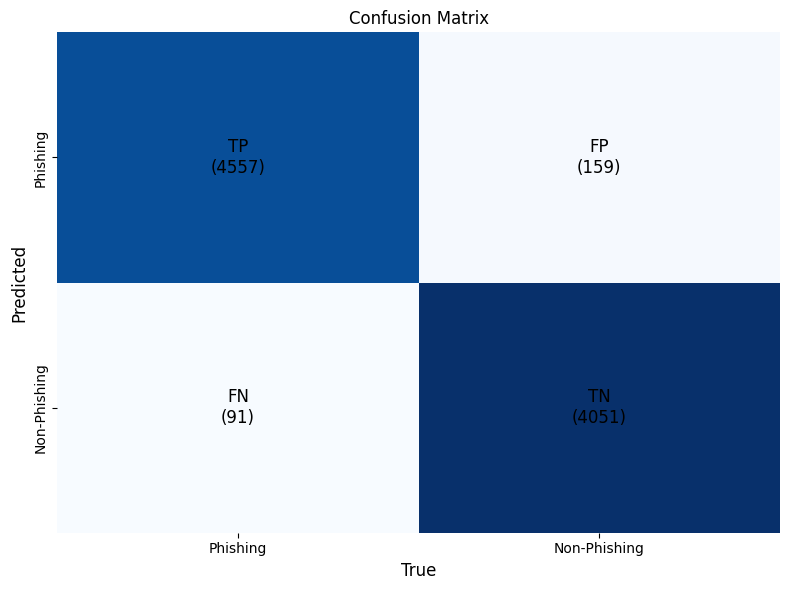

In [9]:
printCM(y_pred, y_test)

Now that the base model is completed, i will move on to making improvements by Hyperparameter tuning

ChatGPT:
I have a problem whereby i am unsure how i can tune my hyperparameters efficiently hence i promted GPT the following:
<br>
How to tune hyperparameters more efficiently instead of trying each parameter one by one
<br>
I was given 4 methods as mentioned below which I then narrowed down to 2 methods that i will use.
<br>
1. Grid Search (Exhausive Search)
2. Randomized Search (Random Search)
3. Bayesian Optimization with scikit-optimize (skopt)
4. Hyperopt (Another Bayesian Optimization Tool)

Attempting Grid Search for Hyperparameter Tuning
<br>
After attempting gridSearch, i determined that it is inefficient and not feasible for the XGBoost model as it takes too long to train as it is more complex than other models such as Random Forest.

In [10]:
"""param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}"""

"param_grid = {\n    'max_depth': [3, 4, 5],\n    'n_estimators': [100, 500, 1000],\n    'learning_rate': [0.01, 0.1, 0.2],\n    'subsample': [0.8, 1.0],\n    'colsample_bytree': [0.8, 1.0]\n}"

In [11]:
"""grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)"""

'grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=3, scoring=\'accuracy\', verbose=1)\n\ngrid_search.fit(X_train, y_train)\nprint("Best parameters found: ", grid_search.best_params_)\nprint("Best accuracy: ", grid_search.best_score_)'

Tuning Hyperparameters (Guide)
<br>
The reason why the param grid/space is different is because they are able to do different tasks.
- Bayes Search can handle a wide range of possibilities and fine-tunes parameters like learning_rate using a log-uniform distribution, ensuring it explores both small and large values efficiently.
- Random Search would inefficiently test too many values if it had continuous ranges, so discrete values help it explore the most important values quickly.
<br>
1. Bayes Search has continuous ranges for hyperparameters, allowing for more flexible, fine-grained exploration.
2. Random Search uses discrete values, providing a quicker, broader search across fixed hyperparameter values.

Attempting Bayesian Optimization with scikit-optimize (skopt) for Hyperparameter Tuning
<br>
Reason for each of the chosen parameter space:
<br>
1. max_depth: (3, 10); Controls tree depth. Chosen between 3 and 10 to balance complexity (deeper trees) and generalization (shallow trees).
2. n_estimators: (100, 1000); Number of boosting rounds. A higher range allows exploring both fast (fewer trees) and accurate (more trees) models.
3. learning_rate: (0.01, 0.3, 'log-uniform'); Learning rate to control how fast the model learns. Smaller rates allow the model to learn in finer steps, 'log-uniform' for evenly searching over a wide scale.
4. subsample: (0.5, 1.0); Fraction of data used per tree. Helps with generalization by using subsets of data. Values between 0.5 and 1 explore how much data is used.
5. colsample_bytree: (0.5, 1.0); Fraction of features used per tree. Encourages diversity in trees by selecting subsets of features. Range from 0.5 to 1 to balance complexity and generalization.
6. reg_alpha: (0.0, 1.0); L1 regularization (for feature selection). Range allows fine-tuning regularization strength to prevent overfitting.
7. reg_lambda: (0.0, 1.0); L2 regularization (for penalizing large coefficients). Adjusts for preventing overfitting, providing flexibility in regularization.

In [12]:
"""param_space = {
    'max_depth': (3, 10),
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.3, 'log-uniform'),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}"""

"param_space = {\n    'max_depth': (3, 10),\n    'n_estimators': (100, 1000),\n    'learning_rate': (0.01, 0.3, 'log-uniform'),\n    'subsample': (0.5, 1.0),\n    'colsample_bytree': (0.5, 1.0),\n    'reg_alpha': (0.0, 1.0),\n    'reg_lambda': (0.0, 1.0)\n}"

In [13]:
"""bayes_search = BayesSearchCV(estimator=XGBClassifier(), search_spaces=param_space, n_iter=10, cv=3, random_state=42)

bayes_search.fit(X_train, y_train)
print("Best parameters found: ", bayes_search.best_params_)
print("Best accuracy: ", bayes_search.best_score_)"""

'bayes_search = BayesSearchCV(estimator=XGBClassifier(), search_spaces=param_space, n_iter=10, cv=3, random_state=42)\n\nbayes_search.fit(X_train, y_train)\nprint("Best parameters found: ", bayes_search.best_params_)\nprint("Best accuracy: ", bayes_search.best_score_)'

Attempting Random search
<br>
Reason for choosing random search is because grid search is exhausive and not optimal for larger parameter spaces whereas random search selects specified number of random combinations which makes it faster and more efficient in this scenario

Reason for each of the chosen parameter:
1. max_depth: [3, 4, 5, 6]; Same purpose as in Bayes Search. A tighter range from 3 to 6 focuses on moderate-depth trees to prevent overfitting.
2. n_estimators: [100, 500, 1000]; A limited set of values for the number of trees to explore models with different complexities and training times.
3. learning_rate: [0.01, 0.1, 0.2]; Small learning rates improve precision but require more trees. The range from 0.01 to 0.2 explores both fast and slow learning models.
4. subsample: [0.8, 0.9, 1.0]; Higher subsampling values, focusing on using nearly the full dataset per tree. Helps control generalization.
5. colsample_bytree: [0.7, 0.8, 1.0]; Range explores how much of the feature set each tree uses. A smaller feature subset (0.7) reduces overfitting, while using all features (1.0) captures the full complexity.

In [14]:
"""param_dist = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}"""

"param_dist = {\n    'max_depth': [3, 4, 5, 6],\n    'n_estimators': [100, 500, 1000],\n    'learning_rate': [0.01, 0.1, 0.2],\n    'subsample': [0.8, 0.9, 1.0],\n    'colsample_bytree': [0.7, 0.8, 1.0]\n}"

1. Estimators is the model that i want to tune
2. Param dict is defined above which contains the hyperparameters and its ranges
3. Number of random parameter combinations to try
4. Number of coss validation checks
5. Verbosity level for logging progress
6. Random seed for reproducibility

In [15]:
"""random_search = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_dist, n_iter=10, cv=3, verbose=1, random_state=42)

random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)"""

'random_search = RandomizedSearchCV(estimator=XGBClassifier(), param_distributions=param_dist, n_iter=10, cv=3, verbose=1, random_state=42)\n\nrandom_search.fit(X_train, y_train)\nprint("Best parameters found: ", random_search.best_params_)\nprint("Best accuracy: ", random_search.best_score_)'

Serializing and Deserializing the python maching learning model as it takes 25 minutes to run and it will not be efficient to run it each time
<br>
The reason why i have opted for joblib and not pickle is because joblib is designed for handling a large numpy array and large dataset more efficiently

In [16]:
"""folder_path = '../best_params/'
randomSearch_model_filename = folder_path + 'XGBoost_random_sebastian.joblib'
bayesSearch_model_filename = folder_path + 'XGBoost_bayes_sebastian.joblib'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)"""

"folder_path = '../best_params/'\nrandomSearch_model_filename = folder_path + 'XGBoost_random_sebastian.joblib'\nbayesSearch_model_filename = folder_path + 'XGBoost_bayes_sebastian.joblib'\nif not os.path.exists(folder_path):\n    os.makedirs(folder_path)"

Seralizing the model

In [17]:
"""
dump(random_search, randomSearch_model_filename)
dump(bayes_search, bayesSearch_model_filename)
"""

'\ndump(random_search, randomSearch_model_filename)\ndump(bayes_search, bayesSearch_model_filename)\n'

Deserializing the model

In [18]:
"""random_search_xgb_best_model = load(randomSearch_model_filename)
bayes_search_xgb_best_model = load(bayesSearch_model_filename)"""

'random_search_xgb_best_model = load(randomSearch_model_filename)\nbayes_search_xgb_best_model = load(bayesSearch_model_filename)'

Fitting and making predictions using the saved hyperparameters from Random Search

In [19]:
"""y_pred = random_search_xgb_best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the XGBoost model using Random Search: ", accuracy)"""

'y_pred = random_search_xgb_best_model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy of the XGBoost model using Random Search: ", accuracy)'

Confusion Matrix for Random Search XGBoost model

In [20]:
"""printCM(y_pred, y_test)"""

'printCM(y_pred, y_test)'

Fitting and making predictions using the saved hyperparameters from Bayes Search

In [21]:
"""y_pred = bayes_search_xgb_best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the XGBoost model using Bayes Search: ", accuracy)"""

'y_pred = bayes_search_xgb_best_model.predict(X_test)\naccuracy = accuracy_score(y_test, y_pred)\nprint("Accuracy of the XGBoost model using Bayes Search: ", accuracy)'

Confusion Matrix for Bayes Search XGBoost model

In [22]:
"""printCM(y_pred, y_test)"""

'printCM(y_pred, y_test)'

Reason for using Confusion Matrix
<br>
True Positive (TP): Correctly identified phishing emails.
<br>
False Positive (FP): Legitimate emails wrongly identified as phishing.
<br>
True Negative (TN): Correctly identified legitimate (non-phishing) emails.
<br>
False Negative (FN): Phishing emails wrongly classified as legitimate.

Overall Evaluation:
<br>
Precision is high (99.72%), meaning the model is very good at making sure emails it classifies as phishing are indeed phishing.
<br>
Recall is also high (97.96%), meaning the model does a great job of identifying phishing emails.
<br>
F1-Score is 98.83%, which indicates a great balance between precision and recall.
<br>
Accuracy is 99.91%, but keep in mind that accuracy may not be the best metric if the classes are imbalanced (e.g., if phishing emails are rare compared to non-phishing emails).

Class Ratios:
1. Training data: 16,571 non-phishing (47%), 18,861 phishing (53%)
2. Test data: 4,210 non-phishing (48%), 4,648 phishing (52%)

These percentages are almost equal, meaning that the classes are balanced. This is good because it indicates that the model won't be biased towards the majority class, and you can rely more on accuracy as a valid metric for evaluating the performance of the model.

Loading Best XGBoost model(Random Search) again for display

In [23]:
folder_path = '../model/'
best_model_filename = folder_path + 'XGBoost_sebastian.joblib'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [24]:
"""joblib.dump(random_search_xgb_best_model, best_model_filename)"""

'joblib.dump(random_search_xgb_best_model, best_model_filename)'

In [26]:
loaded_best_model = joblib.load(best_model_filename)

Accuracy of the best XGBoost model using Random Search:  0.9933393542560397
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4210
           1       0.99      0.99      0.99      4648

    accuracy                           0.99      8858
   macro avg       0.99      0.99      0.99      8858
weighted avg       0.99      0.99      0.99      8858



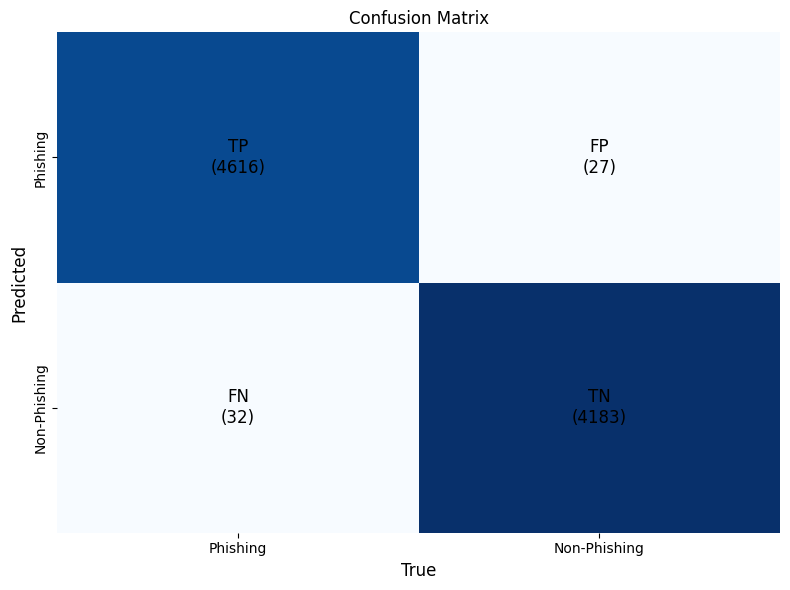

In [27]:
y_pred = loaded_best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the best XGBoost model using Random Search: ", accuracy)
printCM(y_pred, y_test)